# $\mathrm{RESOLVE \quad UNIT \quad \beta}$
## 周波数領域電磁探査法(RESOLVE)データの深層学習を用いた水平多層構造解析

## Import

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sys, os
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sys.path.append('../../')
from dlxem import emexecutor as em
from dlxem import networks, forward

## INPUT

In [10]:
'''
層厚の設定
　学習データの生成から地下構造の内、層数と層厚は固定されます。
　入力値は層数、表層の厚さ、最終層の上端深度、層厚の等分割スケールの４つです。
　全n層の内、表層と最終層の間は線形スケールまたは対数スケールで(n-2)等分されます。
'''
# 層数
nlayer = 30
# 表層の厚さ
init_thick = 0.5
# 最終層の上端深度
last_depth = 150
# 層厚のスケール
split_scale = 'log'
# 層厚の手入力on/off = True / False
manual_input = False
# 層厚

'''

''';

## 1. 層構造の決定

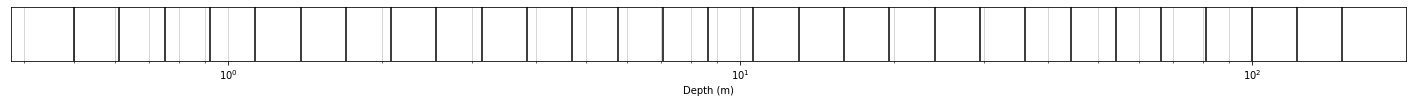

0.0 m | 0.5 m | 0.613 m | 0.751 m | 0.921 m | 1.129 m | 1.385 m | 1.697 m | 2.081 m | 2.551 m | 3.127 m | 3.834 m | 4.7 m | 5.762 m | 7.064 m | 8.66 m | 10.617 m | 13.016 m | 15.956 m | 19.562 m | 23.981 m | 29.4 m | 36.042 m | 44.185 m | 54.169 m | 66.407 m | 81.411 m | 99.805 m | 122.355 m | 150.0 m | 

In [8]:
sys.path.append('../../')
from dlxem.tools import thicks_maker
thicks, depth = thicks_maker(init_thick, last_depth, nlayer, split_scale)
plt.show()
for i in depth:
    print(round(i, 3) ,end=' m | ')

## 2. データ生成

In [3]:
dnn_name = 'albion_s210730'
size = 80000
parallel_num = 8

config = {
    'thicks' : thicks,
    'rmean' : 1,
    'rscat' : 1.5,
    'height_range' : (10, 120),
    'freqs' : [340, 1500, 6600, 31000, 140000],
    'span' : 7.86,
    'add_noise' : True,
    'noise_level' : [10, 10, 20, 40, 50],
    'random_mode' : 'normal'
}

In [4]:
freqs = config['freqs']
span = config['span']
noised = config['add_noise']

dataset_dir = 'database/dataset/'
dsetfile_path = dataset_dir + dnn_name + '_{}_{}.csv'.format(nlayer, size)

model_dir = 'model/'
histfile_path = model_dir + 'history/' + dnn_name + 'history.csv'
nnetfile_path = model_dir + 'network/' + dnn_name + 'network.h5'


if os.path.exists(dsetfile_path):
    df = pd.read_csv(dsetfile_path, header=None)
    print('Datasets already exist')
else:
    resolve = em.Resolve1D(**config)
    data = resolve.multi_process(size, parallel_num)
    df = pd.DataFrame(data)
    df.to_csv(dsetfile_path, header=None, index=False)
    print("-> /" + dsetfile_path)


Datasets already exist


## 3. ニューラルネットワークの学習

In [9]:
batch_size = 400
epochs = 300

In [10]:
#分割
x = df.iloc[:, :11].values
y = df.iloc[:, 11:].values
y = np.log10(y)
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=0)
x_test_org = x_test.copy()

#x正規化
sc = preprocessing.StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [11]:
if os.path.exists(nnetfile_path):
    print('The Specified Neural Network Model Already Exists.')
    network = load_model(nnetfile_path)
    hist_df = pd.read_csv(histfile_path)
else:
    input_dim = x.shape[1]
    output_dim = y.shape[1]
    network = networks.get_dnn(input_dim, output_dim)
    history = network.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_val, y_val))
    network.save(nnetfile_path)
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(histfile_path)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 78400 samples, validate on 800 samples
Epoch 1/300
78400/78400 - 20s - loss: 1.0974 - val_loss: 0.5598
Epoch 2/300
78400/78400 - 19s - loss: 0.5825 - val_loss: 0.6231
Epoch 3/300
78400/78400 - 19s - loss: 0.5198 - val_loss: 0.5141
Epoch 4/300
78400/78400 - 19s - loss: 0.4859 - val_loss: 0.6110
Epoch 5/300
78400/78400 - 19s - loss: 0.4557 - val_loss: 0.4318
Epoch 6/300
78400/78400 - 19s - loss: 0.4368 - val_loss: 0.3882
Epoch 7/300
78400/78400 - 19s - loss: 0.4162 - val_loss: 0.4557
Epoch 8/300
78400/78400 - 19s - loss: 0.3971 - val_loss: 0.3426
Epoch 9/300
78400/78400 - 19s - loss: 0.3823 - val_loss: 0.4381
Epoch 10/300
78400/78400 - 19s - loss: 0.3727 - val_loss: 0.3414
Epoch 11/300
78400/78400 - 19s - loss: 0.3569 - val_loss: 0.3449
Epoch 12/300
78400/78400 - 19s - loss: 0.3487 - val_loss: 0.3036
Epoch 13/300
78400/78400 - 19s - loss: 0.3407 - val_loss: 0.310

## 4. 評価・テスト

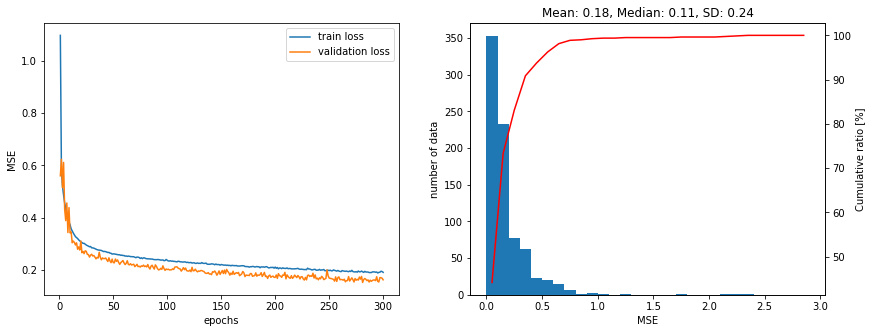

In [14]:
epochx = np.arange(1, epochs+1)
val_mse = hist_df['val_loss'].values
loss = hist_df['loss'].values
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(121)
ax1.plot(epochx, loss, label='train loss')
ax1.plot(epochx, val_mse, label='validation loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('MSE')
ax1.legend()

terr = (y_test - network.predict(x_test))**2
res_mse = np.array([k.mean() for k in terr])

ax2 = fig.add_subplot(122)
max_mse = res_mse.max()
nbins = int(max_mse // 0.1)
bins = [.1*(i) for i in range(nbins)]
n, bins, patches = ax2.hist(res_mse, bins=bins)
y2 = np.add.accumulate(n) / n.sum() * 100
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
ax2.set_xlabel('MSE')
ax2.set_ylabel('number of data')
mean = np.mean(res_mse)
median = np.median(res_mse)
std = np.std(res_mse)
ax2.set_title('Mean: {mean:.2f}, Median: {median:.2f}, SD: {std:.2f}'.format(mean=mean, median=median, std=std))

# 第2軸のプロット
bx2 = ax2.twinx()
lines = bx2.plot(x2, y2, ls='-', color='r', label='Cumulative ratio')
bx2.set_ylabel('Cumulative ratio [%]');

535


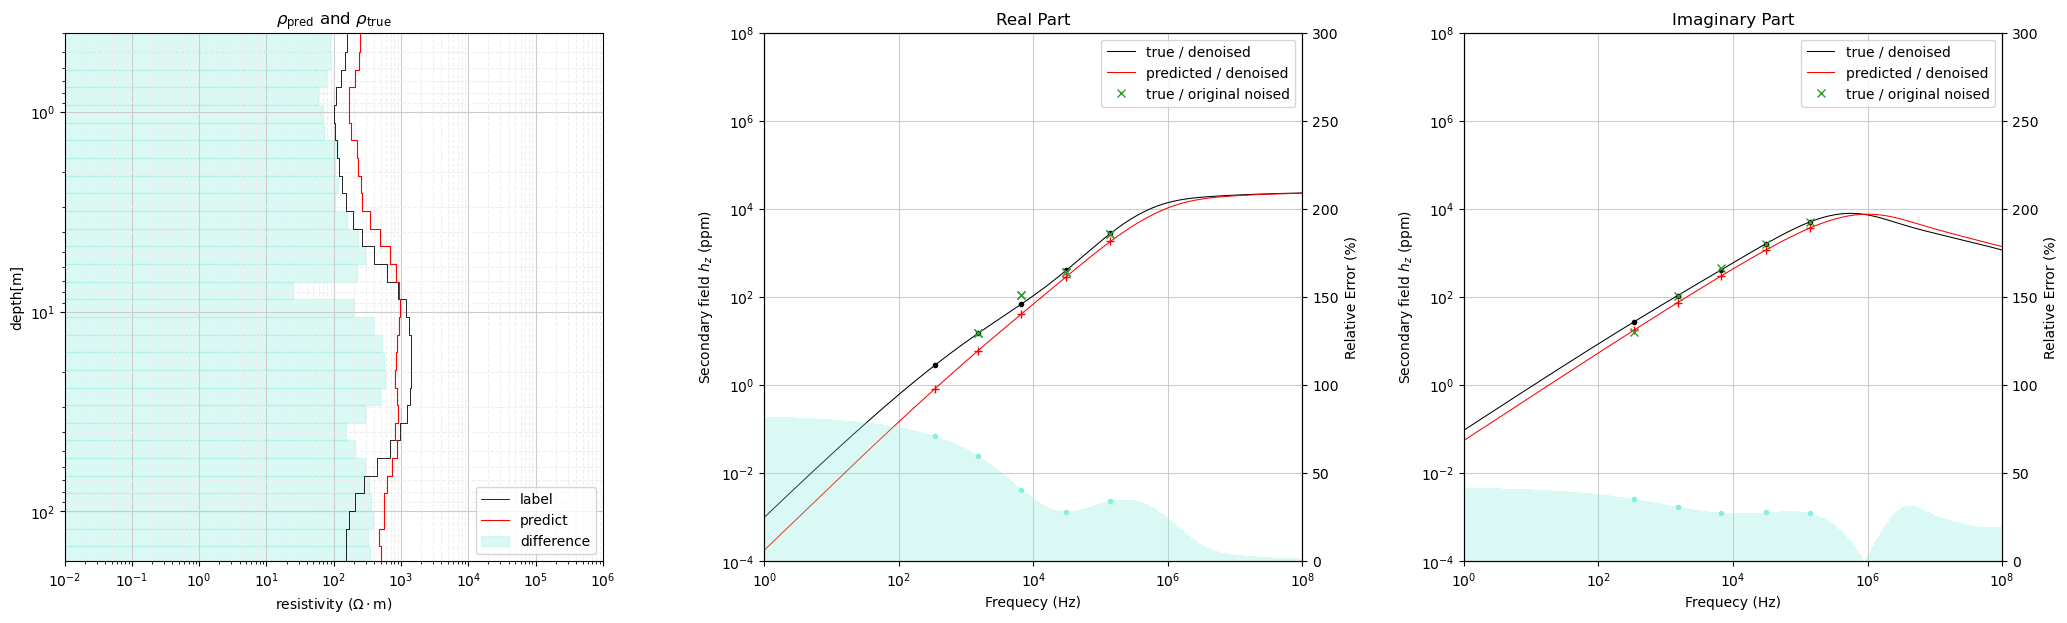

In [23]:
sys.path.append('../../')
from dlxem import myviz as viz

true_res = 10 ** y_test
pred_res = 10 ** network.predict(x_test)
orig_emf = x_test_org[:, :10]
height = x_test_org[:, 10]

test_data_size = len(y_test)
index = np.random.randint(0, test_data_size)

true_res = true_res[index]
pred_res = pred_res[index]
height = height[index]
orig_emf = orig_emf[index]

cfreq_range = (0, 8)
print(index)

fig = viz.resolve.sumplot(thicks, pred_res, true_res, height, span, freqs, cfreq_range, orig_emf, noised=noised, log_depth=True)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.axes[0].set_yscale('log')

## 5. DL解析

In [24]:
field_name = 'sendai_flv'
## データは表形式、CSV / XYZ(TXT) から選べる
datafile_format = 'CSV'

# データファイルのパス
data_directory = "database/survey/sendai_resolve/EM_data/HEM_line_base.csv"
# 保存先のパス
save_path = 'database/result/sd_resolve/{}_result_by_{}.csv'.format(field_name, dnn_name)

# TXTの場合の冒頭スキップ行数
skiprows = 8
pickup_col = [0, 3, 4, 7, 25, 24, 22, 21, 20, 31, 30, 28, 27, 26, 5]

header = ['line No.', 'easting', 'northing', 'elevation', 'EM1R', 'EM2R', 'EM3R', 'EM4R', 'EM5R', 'EM1I', 'EM2I', 'EM3I', 'EM4I', 'EM5I', 'bird_height']
dnnx_index = ['EM1R', 'EM2R', 'EM3R', 'EM4R', 'EM5R', 'EM1I', 'EM2I', 'EM3I', 'EM4I', 'EM5I', 'bird_height']
loc_index = ['line No.', 'easting', 'northing', 'elevation']

if os.path.exists(save_path):
    print('preprocessing has already done')
    pass

else:
    if datafile_format == 'XYZ':
        data = np.loadtxt(data_directory, skiprows=skiprows)
        dfd = data[:, pickup_col]
        df = pd.DataFrame(dfd, columns=header)

    elif datafile_format == 'CSV':
        data = pd.read_csv(data_directory)
        dfd = data.iloc[:, pickup_col].values
        df = pd.DataFrame(dfd, columns=header)

    # 欠損値を含む行
    df = df.replace('*', np.nan)
    df = df.dropna(how='any')
    x = df[dnnx_index].values
    loc = df[loc_index].values

    stdx = sc.transform(x)
    res = network.predict(stdx)
    res = 10 ** res

    numlayer = len(depth)
    res_header = ['R{}'.format(i+1) for i in range(numlayer)]
    header = [*header, *res_header]
    rdata = np.hstack([loc, x, res])
    rdf = pd.DataFrame(rdata)
    rdf.to_csv(save_path, header=header, index=False)

/Users/quetzal/opt/anaconda3/envs/dlabpy37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
'''
sys.path.append('../../')
from dlxem import myviz as viz

test_data_size = len(y_test)
div25 = test_data_size // 25

for num in range(div25):
    index = np.array([25*num + j for j in range(25)])
    numbers = index + 1

    true_res = 10 ** y_test[index]
    pred_res = 10 ** network.predict(x_test[index])
    height = x_test_org[index, 10]

    fig = viz.resolve.models_poster25(thicks, pred_res, true_res, height, numbers, log_depth=True)
'''

"\nsys.path.append('../../')\nfrom dlxem import myviz as viz\n\ntest_data_size = len(y_test)\ndiv25 = test_data_size // 25\n\nfor num in range(div25):\n    index = np.array([25*num + j for j in range(25)])\n    numbers = index + 1\n\n    true_res = 10 ** y_test[index]\n    pred_res = 10 ** network.predict(x_test[index])\n    height = x_test_org[index, 10]\n\n    fig = viz.resolve.models_poster25(thicks, pred_res, true_res, height, numbers, log_depth=True)\n"